# -1) imports de librairies

In [98]:
import numpy as np
import pandas as pd
import os
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

# -2) Chargement data

In [2]:
default_path='c:\\Users\yvesm\Documents\Anaconda3'
os.chdir(default_path)

input_fileTrain = "projetTrain.csv"
input_fileValid = "projetValid.csv"

PT = pd.read_csv(input_fileTrain, header = 0)
PV = pd.read_csv(input_fileValid, header = 0)


# -3)Travail sur les jeux de données

In [ ]:
#Ajout de la colonne target sur le PV avec la valeur 3
PV_target = PV.copy()
PV_target["target"]=3

#Sauvegarde de la colonne target au besoin
target_num=PT["target"]

#concactenation de PT et PV
PTV=PT.append(PV_target,ignore_index=True)

#decompte du nombre des NA dans les differentes colonnes
col_na=PTV.isnull().sum()
col_na[col_na>0]

#Remplacer les NA par la mediane de la colonne
PTV = PTV.fillna(PTV.median())

#Decomposition de la colonne Product_Info_2 en deux colonnes ( une string et l'autre num)
#decompo=PTV.Product_Info_2.str.extract('([ABCDEF])(\d)')
#decompo.columns=["Product_Info_2_prefixe","Product_Info_2_sufixe"]
#PTV.insert(loc=2, column='Product_Info_2_pre', value=decompo.Product_Info_2_prefixe)
#PTV.insert(loc=3, column='Product_Info_2_suf', value=decompo.Product_Info_2_sufixe)

#Convertion des colonnes Product_Info_2_pre et Product_Info_2_suf en cathégorical et int
#PTV["Product_Info_2_pre"] = PTV.Product_Info_2_pre.astype('category')
#PTV["Product_Info_2_suf"] = PTV.Product_Info_2_suf.astype(int)

#Suppression de la colonne Id
del PTV["Id"]

#transformation de la colonne Product_Info_2 en cathegorie
PTV["Product_Info_2"] = PTV.Product_Info_2.astype('category')

#Transformation de la colonne Product_Info_2 en matrixe de 0 et 1
PTV_dummies = pd.get_dummies(PTV,columns=["Product_Info_2"], drop_first=False)
#PTV_dummies = pd.get_dummies(PTV["Product_Info_2"])
PTV_dummies["Target"]=PTV_dummies.target
del PTV_dummies["target"]

PTV=PTV_dummies.copy()

#Separation du jeu de donné en Train et Valid
PT=PTV[PTV.Target!=3]
PV=PTV[PTV.Target==3]

#transformation de la colonne target en cathegorie (PT.dtypes pour voir les types des colonnes)
PT["Target"] = PT.Target.astype('category')
 
#Suppression de la colonne target de PV
del PV["Target"]

#Selection de 20000 lignes de notre jeu d'apprentissage de manière aléatoire pour evaluer nos modele
PT_Test=PT.sample(20000)
PT_Train=PT.drop(PT_Test.index)

PT_Train_X=PT_Train.loc[:, PT_Train.columns != 'Target']
PT_Train_Y=PT_Train["Target"]

PT_Test_X=PT_Test.loc[:, PT_Test.columns != 'Target']
PT_Test_Y=PT_Test["Target"]


# -4) Data Exploration

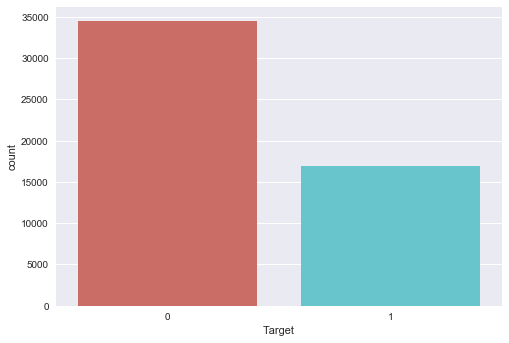

In [30]:
#Plot des proportions de categories 1 et 0
sb.countplot(x="Target", data=PT, palette='hls')
plt.show()

In [5]:
PT.groupby("Target").mean()

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,...,Product_Info_2_B2,Product_Info_2_C1,Product_Info_2_C2,Product_Info_2_C3,Product_Info_2_C4,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1
Target,,,,,,,,,,,,,,,,,,,,,
0,1.028374,24.742950,0.294507,2.007970,2.682231,1.042779,0.436324,0.714724,0.318324,0.506550,...,0.014491,0.005333,0.002724,0.005304,0.003043,0.130887,0.121555,0.261977,0.141640,0.038084
1,1.021152,23.747778,0.399313,2.004858,2.651380,1.043252,0.342964,0.691913,0.239684,0.393359,...,0.028202,0.003910,0.002074,0.004681,0.004740,0.065292,0.074653,0.203282,0.261939,0.058656


# -5) Feature Selection

#TREE BASED FEATURE SELECTION

In [6]:
clf_fs = ExtraTreesClassifier()
clf_fs = clf_fs.fit(PT_Train_X, PT_Train_Y)

model = SelectFromModel(clf_fs, prefit=True)
X_new = model.transform(PT_Train_X)
mask = model.get_support(indices=False)    
X_new = PT_Train_X.loc[:, mask]  

featured_col_names_tree = X_new.columns 
featured_col_names_tree


Index(['Product_Info_4', 'Product_Info_6', 'Ins_Age', 'Ht', 'Wt', 'BMI',
       'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_4',
       'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_3', 'InsuredInfo_4',
       'InsuredInfo_6', 'Insurance_History_4', 'Insurance_History_5',
       'Insurance_History_8', 'Family_Hist_1', 'Family_Hist_2',
       'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1',
       'Medical_History_2', 'Medical_History_4', 'Medical_History_9',
       'Medical_History_15', 'Medical_History_23', 'Medical_History_29',
       'Medical_History_34', 'Medical_History_39', 'Medical_History_41',
       'Medical_Keyword_3', 'Medical_Keyword_15', 'Product_Info_2_A7',
       'Product_Info_2_D4'],
      dtype='object')

#RECURCIVE FEATURE SELECTION

In [66]:
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 6)
fit = rfe.fit(PT_Train_X, PT_Train_Y)
#print(fit.n_features_)
#print(fit.support_)
#print(fit.ranking_)
mask = fit.get_support(indices=False)   
X_new = PT_Train_X.loc[:, mask]  
featured_col_names_rfe = X_new.columns 
featured_col_names_rfe

Index(['Wt', 'BMI', 'Medical_Keyword_3', 'Medical_Keyword_15',
       'Medical_Keyword_38', 'Product_Info_2_A7'],
      dtype='object')

# -6) DATA VIZ

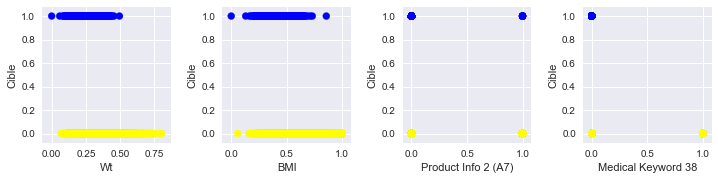

In [72]:
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = plt.subplot(2,4,1)

clist = ['yellow', 'blue']
colors = [clist[c] for c in PT_Train_Y]

ax1.scatter(PT_Train_X.Wt, PT_Train_Y, c=colors)
plt.xlabel('Wt')
plt.ylabel('Cible')

ax2 = plt.subplot(2,4,2)
ax2.scatter(PT_Train_X.BMI, PT_Train_Y, color=colors)
plt.xlabel('BMI')
plt.ylabel('Cible')

ax3 = plt.subplot(2,4,3)
ax3.scatter(PT_Train_X.Medical_Keyword_3, PT_Train_Y, color=colors)
plt.xlabel('Product Info 2 (A7)')
plt.ylabel('Cible')

ax4 = plt.subplot(2,4,4)
ax4.scatter(PT_Train_X.Medical_Keyword_38, PT_Train_Y, color=colors)
plt.xlabel('Medical Keyword 38')
plt.ylabel('Cible')

plt.show()

In [ ]:
#Copie des features importantes pour la suite
feature_reduce=featured_col_names_tree

# -7) Logistic Regression Penalisée

In [130]:
clf_lr = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
clf_lr.fit(PT_Train_X[feature_reduce], PT_Train_Y)

predict_lr = clf_lr.predict(PT_Test_X[feature_reduce])
accuracy_score(PT_Test_Y, predict_lr)

0.65064999999999995

In [131]:
clf_lr = SGDClassifier(loss='log')

# Utilisation de grid sur les parametres à faire varier
param_grid = { 
    "penalty" : ['l1','l2','elasticnet'],
    "alpha" : [0.0001,0.1,0.2,0.3,0.4,0.5,0.5,0.6,0.7,0.8,0.9,1],
    "l1_ratio" : [0,0.15,0.3,0.45,0.6,0.75,0.8,0.95]}
#Test des differents parametres
CV_lr = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv= 10)
CV_lr.fit(PT_Train_X[feature_reduce], PT_Train_Y)
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'alpha': 0.0001, 'l1_ratio': 0.95, 'penalty': 'elasticnet'}
0.6842994168445875


In [141]:
clf_lr_best = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.95)
clf_lr_best.fit(PT_Train_X[feature_reduce] , PT_Train_Y)

predict_lr_best = clf_lr_best.predict(PT_Test_X[feature_reduce])
accuracy_score(PT_Test_Y, predict_lr_best)

0.70889999999999997

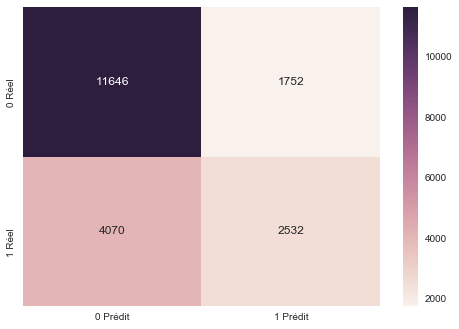

In [142]:
cm = pd.DataFrame(confusion_matrix(PT_Test_Y, predict_lr_best),  columns=['0 Prédit', '1 Prédit'],
    index=['0 Réel', '1 Réel'])
sb.heatmap(cm, annot=True,fmt="d")
plt.show()

C:\Users\yvesm\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


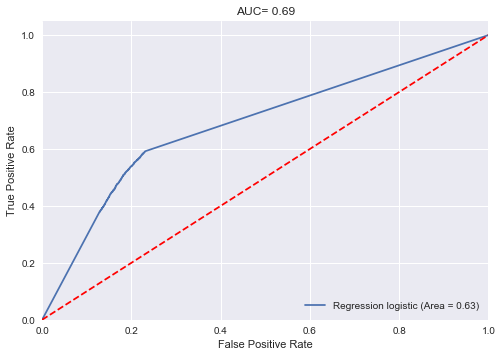

In [149]:
logit_roc_auc = roc_auc_score(PT_Test_Y, predict_lr_best)
fpr, tpr, thresholds = roc_curve(PT_Test_Y, clf_lr_best.predict_proba(PT_Test_X[feature_reduce])[:,1])
mod_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Regression logistic (Area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC= %0.2f'%mod_auc)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# -7) Random Forest

In [15]:
#Modele Parametres par defaut
clf_RF = RandomForestClassifier(n_estimators=100,max_features=6)
clf_RF.fit(PT_Train_X[feature_reduce], PT_Train_Y)

predict_RF= clf_RF.predict(PT_Test_X[feature_reduce])
accuracy_score(PT_Test_Y, predict_RF)

0.82140000000000002

In [16]:
print(classification_report(PT_Test_Y, predict_RF))

             precision    recall  f1-score   support

          0       0.88      0.85      0.87     13398
          1       0.72      0.75      0.74      6602

avg / total       0.82      0.82      0.82     20000



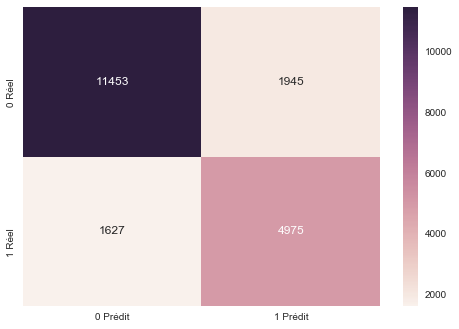

In [29]:
cm = pd.DataFrame(confusion_matrix(PT_Test_Y, predict_RF),  columns=['0 Prédit', '1 Prédit'],
    index=['0 Réel', '1 Réel'])
sb.heatmap(cm, annot=True,fmt="d")
plt.show()

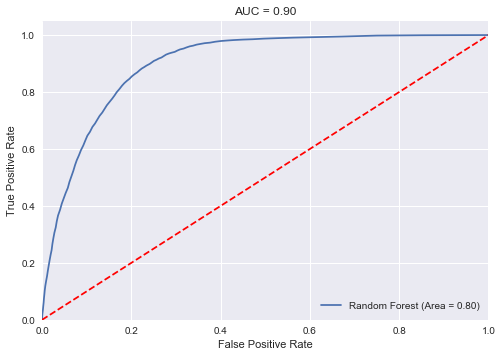

In [89]:
logit_roc_auc = roc_auc_score(PT_Test_Y, predict_RF)
fpr, tpr, thresholds = roc_curve(PT_Test_Y, clf_RF.predict_proba(PT_Test_X[feature_reduce])[:,1])
mod_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (Area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %0.2f' %mod_auc)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [36]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 
 
# Utilisation de grid sur les parametres à faire varier
param_grid = { 
           "n_estimators" : [50, 100, 150,200], #Le nombre d'arbre
           "max_depth" : [5, 10, 15, 20, 25, 30], #La profondeur des arbres
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
#Test des differents parametres sue le modele de Random Forest 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(PT_Train_X[feature_reduce], PT_Train_Y)
print(CV_rfc.best_params_)

{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 150}


In [37]:
clf_RF_best = RandomForestClassifier(n_estimators=150,max_features='sqrt',max_depth=20, min_samples_leaf=2)
clf_RF_best.fit(PT_Train_X[feature_reduce], PT_Train_Y)

predict_RF_best= clf_RF_best.predict(PT_Test_X[feature_reduce])
accuracy_score(PT_Test_Y, predict_RF_best)

0.82225000000000004

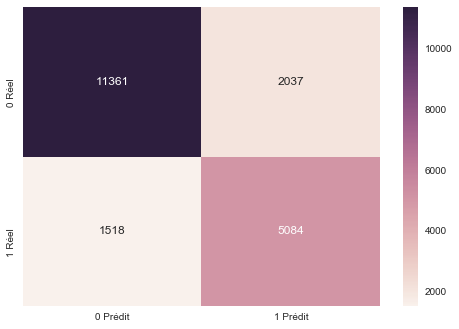

In [64]:
cm = pd.DataFrame(confusion_matrix(PT_Test_Y, predict_RF_best),  columns=['0 Prédit', '1 Prédit'],
    index=['0 Réel', '1 Réel'])
sb.heatmap(cm, annot=True,fmt="d")
plt.show()

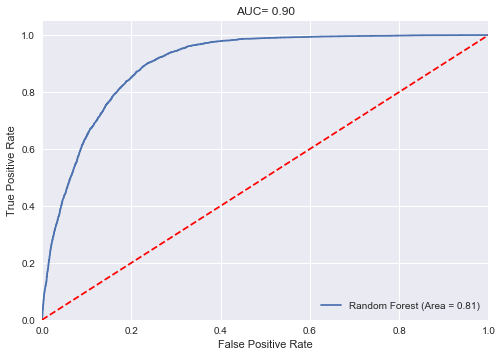

In [90]:
logit_roc_auc = roc_auc_score(PT_Test_Y, predict_RF_best)
fpr, tpr, thresholds = roc_curve(PT_Test_Y, clf_RF_best.predict_proba(PT_Test_X[feature_reduce])[:,1])
mod_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (Area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC= %0.2f'%mod_auc)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# -8) Linear SVC

In [20]:
#par défaut un noyau RBF et C = 1.0
clf_SVC = svm.SVC()
clf_SVC.fit(PT_Train_X[feature_reduce],PT_Train_Y)
predict_SVC = clf_SVC.predict(PT_Test_X[feature_reduce])
#matrice de confusion
print(confusion_matrix(PT_Test_Y,predict_SVC))
#succès en test
print(accuracy_score(PT_Test_Y,predict_SVC)) 

[[11625  1773]
 [ 3708  2894]]
0.72595


In [21]:
clf_SVC = svm.SVC()
#combinaisons de paramètres à évaluer
parametres = [{'C':[0.1,1,10],'kernel':['rbf','linear']}]

#évaluation en validation croisée de 3 x 2 = 6 configurations
#accuracy sera le critère à utiliser pour sélectionner la meilleure config

CV_svc = GridSearchCV(estimator=clf_SVC,param_grid=parametres,scoring='accuracy')
#lancer la recherche – attention, gourmand en calculs
grille = CV_svc.fit(PT_Train_X[feature_reduce],PT_Train_Y)

#meilleur paramétrage
print(grille.best_params_) 
#meilleur performance estimée en interne par cross validation
print(grille.best_score_)

{'C': 1, 'kernel': 'linear'}
0.8178515662343456


NameError: name 'X_test' is not defined

In [33]:
clf_SVC = svm.SVC(kernel="linear", C=1,probability=True)
clf_SVC.fit(PT_Train_X[feature_reduce],PT_Train_Y)
predict_SVC = clf_SVC.predict(PT_Test_X[feature_reduce])
#succès en test
print(accuracy_score(PT_Test_Y,predict_SVC)) 

[[11367  2031]
 [ 1775  4827]]
0.8097


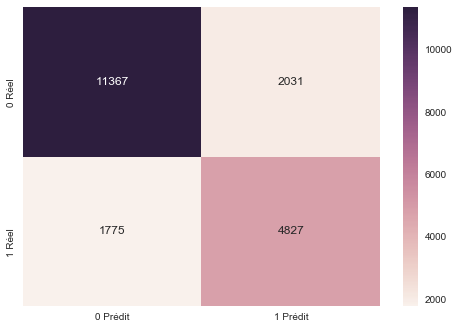

In [144]:
cm = pd.DataFrame(confusion_matrix(PT_Test_Y, predict_SVC),  columns=['0 Prédit', '1 Prédit'],
    index=['0 Réel', '1 Réel'])
sb.heatmap(cm, annot=True,fmt="d")
plt.show()

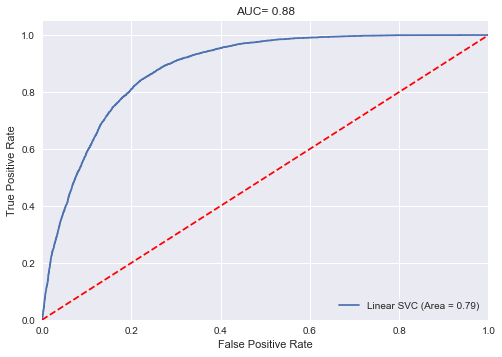

In [148]:
logit_roc_auc = roc_auc_score(PT_Test_Y, predict_SVC)
fpr, tpr, thresholds = roc_curve(PT_Test_Y, clf_SVC.predict_proba(PT_Test_X[feature_reduce])[:,1])
mod_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Linear SVC (Area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC= %0.2f'%mod_auc)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()